#Random Forest

In [10]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing   import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import accuracy_score, balanced_accuracy_score
from sklearn.inspection      import permutation_importance

# Leer CSV

In [11]:
!wget -P ./../data/ https://raw.githubusercontent.com/pbonillor/DATA_SCIENCE_CON_PYTHON/main/MODULO_II/adult.csv

--2023-11-03 14:19:03--  https://raw.githubusercontent.com/pbonillor/DATA_SCIENCE_CON_PYTHON/main/MODULO_II/adult.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5277526 (5.0M) [text/plain]
Saving to: ‘./../data/adult.csv.2’

adult.csv.2         100%[===================>]   5.03M  --.-KB/s    in 0.06s   

2023-11-03 14:19:03 (82.2 MB/s) - ‘./../data/adult.csv.2’ saved [5277526/5277526]



In [12]:
df = pd.read_csv("../data/adult.csv")

In [13]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


# Qué queremos predecir? -> `df.income`

In [17]:
df.income

0        <=50K
1        <=50K
2         >50K
3         >50K
4        <=50K
         ...  
48837    <=50K
48838     >50K
48839    <=50K
48840    <=50K
48841     >50K
Name: income, Length: 48842, dtype: object

# <center> Pre-processing
- Replace categories with their numeric codes
- handle missing continuous values
- Select target variable
- Split train and validation sets

# Missings

# Categories

In [21]:
cat  = df.select_dtypes(include=[object]).columns
num  = df.select_dtypes(exclude=[object, 'datetime64','timedelta64']).columns
time = df.select_dtypes(include=['datetime64']).columns

print("\nNumerical features:\n", num.values)
print("\nCategorical features:\n", cat.values)
print("\nDate/time features:\n", time.values)


Numerical features:
 ['age' 'fnlwgt' 'educational-num' 'capital-gain' 'capital-loss'
 'hours-per-week']

Categorical features:
 ['workclass' 'education' 'marital-status' 'occupation' 'relationship'
 'race' 'gender' 'native-country' 'income']

Date/time features:
 []


In [22]:
df[cat] = df[cat].apply(LabelEncoder().fit_transform)
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,39,0
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,39,0
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,39,1
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,39,1
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,39,0


# Split Train (80%) and validation (20%) ¡STRATIFIED!

In [23]:
x = df.drop("income", axis="columns")
y = df["income"]

x_train, x_valid, y_train, y_valid = train_test_split(x, y,
                                                      test_size=0.2,
                                                      stratify=y,
                                                      random_state=0)

# Train Random Forest

In [24]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1)

# Evaluate Random Forest
Use Random Forest to prect new data

In [25]:
preds = model.predict(x_valid)
preds

array([0, 0, 0, ..., 0, 1, 1])

Show some **metrics**

In [27]:
print("Accuracy (Caution):", accuracy_score(y_valid, preds)*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_valid, preds)*100)

Accuracy (Caution): 85.70989865902344
Balanced accuracy:  77.70855428539656


# (ensemble tree specific) Feature importance
Este grafico nos mustra las varaibles más importantes en la que se fija nuestro modelo
<font color='red'>Caution: Can inflate the importance of numerical features.</font>


In [28]:
sb.set()

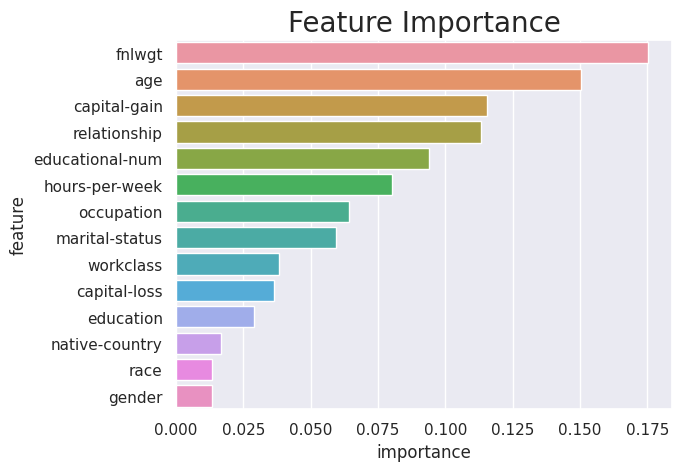

In [29]:
fi = pd.DataFrame({
      'feature':     x.columns,
      'importance':  model.feature_importances_
     }).sort_values('importance', ascending=False).reset_index(drop=True)

# Plot
sb.barplot(x=fi.importance, y=fi.feature).set_title("Feature Importance",  fontsize=20);

# [Permutation Feature Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html) (Better, but slower)
Otra forma de calcular las varaibles más importantes.

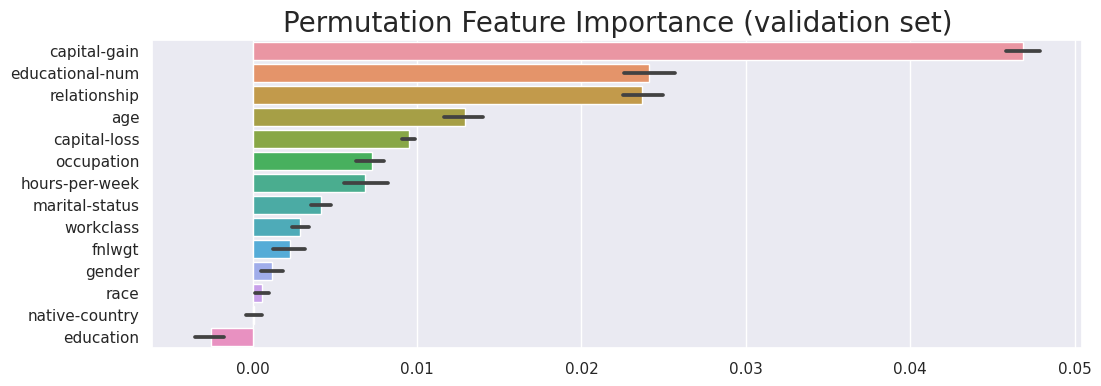

In [30]:
# Compute Permutation Feature Importance
pfi = permutation_importance(model, x_valid, y_valid, n_repeats=10, random_state=0, n_jobs=-1)

# Clean data
sorted_idx = pfi.importances_mean.argsort()[::-1]
pfi_df = pd.DataFrame(data=pfi.importances[sorted_idx].T, columns=x_valid.columns[sorted_idx])

# Plot (This can be barplot, boxplot, violinplot,...)
plt.figure(figsize=(12,4))
sb.barplot(data=pfi_df, orient="h").set_title("Permutation Feature Importance (validation set)",  fontsize=20);